# Lymphoid_No6_gene-module-scoring

In [1]:
outdir='/home/jovyan/projects/kk14_DCM-lymphoid/notebooks/final/figures/'

## Import required modules

In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scikit_posthocs as sp

# silence scanpy that prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
sc.logging.print_header()
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=200, facecolor='white')

scanpy==1.7.1 anndata==0.7.5 umap==0.5.1 numpy==1.20.1 scipy==1.6.1 pandas==1.2.3 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.9.0 louvain==0.7.0 leidenalg==0.8.3


## Functions

In [4]:
def plot_scores(adata, geneset, pathway_name,
                 figsize=(3,6),
                 dot_size=150,
                 bbox_to_anchor=(1.4, 1.05),
                 margin_x=0.2,
                 margin_y=0.05,
                 cmap='OrRd',
                 invert_y=False,
                 yticks=True,
                 save_png=None,
                 dpi=None,
                ):
    
    # scoring pathway
    ad = adata.copy()
    sc.tl.score_genes(ad, gene_list=geneset, score_name=pathway_name)
    # calculate mean per genotype*celltype
    df = ad.obs[['Gene','cell_states',pathway_name]].groupby(['Gene','cell_states']).mean().reset_index()
    
    # comparison vs control, statistical test
    df2 = ad.obs[['Gene','cell_states',pathway_name]]
    count=0
    for cell in df2['cell_states'].cat.categories:
        count+=1
        df3=df2[df2['cell_states']==cell]
        res=sp.posthoc_ttest(df3, val_col=pathway_name, group_col='Gene', equal_var=False, p_adjust='holm')
        res_df = pd.DataFrame({
            'Gene':res['control'].index,
            'cell_states':cell,
            'pval_vs_control':res['control'].values
        })
        if count==1:
            res_con=res_df
        else:
            res_con=pd.concat([res_con,res_df],axis=0)
        del df3, res, res_df
    res_con['index']=range(len(res_con))
    res_con.set_index('index',inplace=True)
    
    # adjusting p-value with the number of celltypes 
    res_con['padj_vs_control']=np.clip(res_con['pval_vs_control']*len(df2['cell_states'].cat.categories),0,1)
    res_con['edgecolor']='none'
    res_con.loc[res_con.query('padj_vs_control<0.05').index,'edgecolor']='black'
    
    # merge
    df = pd.merge(df, res_con, on=['Gene','cell_states'])
    
    # visualise
    plt.figure(figsize=figsize)
    scatter = plt.scatter(x=df['Gene'], y=df['cell_states'], 
                          c=df[pathway_name], s=200, 
                          cmap=cmap, edgecolor=df['edgecolor'], linewidths=1.5)
    plt.colorbar(scatter, aspect=50)
    plt.margins(x=margin_x, y=margin_y)
    plt.title(pathway_name)
    plt.xticks(rotation=90)
    if invert_y: plt.gca().invert_yaxis()
        
    if yticks:
        pass
    else:
        plt.yticks(ticks=[])
    
    if save_png != None:
        plt.savefig(save_png, dpi=dpi, transparent=True, bbox_inches="tight")

    plt.show()

In [5]:
def plot_scores2(adata, geneset_dict, title,
                 figsize=(3,6),
                 dot_size=200,
                 n_legend_element=4,
                 bbox_to_anchor=(1, 1),
                 margin_x=0.2,
                 margin_y=0.05,
                 cmap='OrRd',
                 invert_y=False,
                 yticks=True,
                 save_png=None,
                 dpi=None,
                ):
    
    ad = adata.copy()
    
    # scoring the geneset dictionary
    for key in geneset_dict.keys():
        sc.tl.score_genes(ad, gene_list=geneset_dict[key], score_name=key)
    df = ad.obs[['Gene']+list(geneset_dict.keys())].groupby(['Gene']).mean().reset_index()
    df=pd.melt(df, id_vars=['Gene'], value_vars=list(geneset_dict.keys()))
    df.rename(columns={'variable':'geneset'}, inplace=True)
    
    # comparison vs control, statistical test
    df2 = ad.obs[['Gene']+list(geneset_dict.keys())]
    
    count=0
    for key in geneset_dict.keys():
        count+=1
        df3=df2[['Gene',key]]
        res=sp.posthoc_ttest(df3, val_col=key, group_col='Gene', equal_var=False, p_adjust='holm')
        res_df = pd.DataFrame({
            'Gene':res['control'].index,
            'geneset':key,
            'pval_vs_control':res['control'].values
        })
        if count==1:
            res_con=res_df
        else:
            res_con=pd.concat([res_con,res_df],axis=0)
        del df3, res, res_df
    res_con['index']=range(len(res_con))
    res_con.set_index('index',inplace=True)
    
    # adjusting p-value with the number of celltypes 
    res_con['padj_vs_control']=np.clip(res_con['pval_vs_control']*len(geneset_dict.keys()),0,1)
    res_con['edgecolor']='none'
    res_con.loc[res_con.query('padj_vs_control<0.05').index,'edgecolor']='black'
    
    # merge
    df = pd.merge(df, res_con, on=['Gene','geneset'])
    
    # visualise
    plt.figure(figsize=figsize)
    scatter = plt.scatter(x=df['Gene'], y=df['geneset'], 
                          c=df['value'], s=dot_size, 
                          cmap=cmap, edgecolor=df['edgecolor'], linewidths=1.5)
    plt.colorbar(scatter, aspect=10)
    plt.margins(x=margin_x, y=margin_y)
    plt.title(title)
    plt.xticks(rotation=90)
    if invert_y: plt.gca().invert_yaxis()
        
    if yticks:
        pass
    else:
        plt.yticks(ticks=[])
    
    if save_png != None:
        plt.savefig(save_png, dpi=500, transparent=True, bbox_inches="tight")

    plt.show()

In [6]:
def rank_genes_groups_to_df(adata, cell):
    
    dic = adata.uns['rank_genes_groups'] 
    
    df = pd.DataFrame({
        'names' : dic['names'][cell],
        'scores' : dic['scores'][cell],
        'pvals' : dic['pvals'][cell],
        'pvals_adj' : dic['pvals_adj'][cell],
        'logfoldchanges' : dic['logfoldchanges'][cell]
    })
    
    return df

## Read in normalised lymphoid data

In [7]:
adata = sc.read_h5ad('/nfs/team205/kk18/DCM/anndata/Lymphoid_annotated_scVI-UMAP_210513.h5ad')

# rename 'mutation negative' to 'PVneg'
adata.obs.replace({'Gene':{'mutation negative':'PVneg'}}, inplace=True)

# remove 'unclassified.1' and 'unclassified.2'
adata = adata[adata.obs['cell_states'].isin(['unclassified.1','unclassified.2'])==False]

print(adata.X.data[:10])
adata

[1.8285189 1.8285189 2.4379303 1.8285189 2.8138494 1.8285189 1.8285189
 1.8285189 1.8285189 1.8285189]


View of AnnData object with n_obs × n_vars = 16726 × 25134
    obs: 'Sample', 'Patient', 'Gender', 'Region', 'Diagnosis', 'Gene', 'Clinical.dominant.mutation', 'n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'scrublet_score_z', 'scrublet_score_log', 'solo_score', 'cell_type', 'cell_states'
    var: 'gene_ids-DCM', 'feature_types-DCM', 'genome-DCM', 'gene_ids-Harvard-Nuclei-HCA', 'feature_types-Harvard-Nuclei-HCA', 'gene_ids-Sanger-Nuclei-HCA', 'feature_types-Sanger-Nuclei-HCA', 'gene_ids-Sanger-Cells-HCA', 'feature_types-Sanger-Cells-HCA', 'gene_ids-Sanger-CD45-HCA', 'feature_types-Sanger-CD45-HCA', 'n_counts'
    uns: 'Cells_Nuclei_colors', '_scvi', 'cell_states_20210305_colors', 'hvg', 'leiden', 'leiden_scVI_colors', 'neighbors', 'umap'
    obsm: 'X_scVI', 'X_umap'
    obsp: 'connectivities', 'distances'

## Select genotypes to analyse

In [8]:
adata = adata[adata.obs['Gene'].isin(['control', 'LMNA', 'TTN', 'RBM20', 'PKP2', 'PVneg'])].copy()
adata.obs['Gene'].cat.reorder_categories(new_categories=['control', 'LMNA', 'TTN', 'RBM20', 'PKP2', 'PVneg'],
                                              inplace=True)

## Devide adata into LV and RV

In [9]:
LV = adata[adata.obs['Region'].isin(['AP', 'FW', 'S'])]
RV = adata[adata.obs['Region'].isin(['RV'])]

## Load gene sets

In [10]:
# Cytotoxicity, KEGG-hsa04650
KEGG_cytox=pd.read_table('/home/jovyan/projects/kk14_DCM-lymphoid/data/genesets/MSigDB/KEGG_NATURAL_KILLER_CELL_MEDIATED_CYTOTOXICITY.txt', header=[0,1])
KEGG_cytox = list(KEGG_cytox['KEGG_NATURAL_KILLER_CELL_MEDIATED_CYTOTOXICITY']['> Natural killer cell mediated cytotoxicity'])
print(len(KEGG_cytox))

137


In [11]:
# Leukocyte transendothelial migration, KEGG-hsa04670
KEGG_LTEM=pd.read_table('/home/jovyan/projects/kk14_DCM-lymphoid/data/genesets/MSigDB/KEGG_LEUKOCYTE_TRANSENDOTHELIAL_MIGRATION.txt', header=[0,1])
KEGG_LTEM = list(KEGG_LTEM['KEGG_LEUKOCYTE_TRANSENDOTHELIAL_MIGRATION']['> Leukocyte transendothelial migration'])
print(len(KEGG_LTEM))

116


In [12]:
# Cell cycle, KEGG-hsa04110
KEGG_CC=pd.read_table('/home/jovyan/projects/kk14_DCM-lymphoid/data/genesets/MSigDB/KEGG_CELL_CYCLE.txt', header=[0,1])
KEGG_CC = list(KEGG_CC['KEGG_CELL_CYCLE']['> Cell cycle'])
print(len(KEGG_CC))

125


## Gene scoring

### Cytotoxicity

computing score 'LV, Cytotoxicity'
    finished: added
    'LV, Cytotoxicity', score of gene set (adata.obs).
    1092 total control genes are used. (0:00:00)


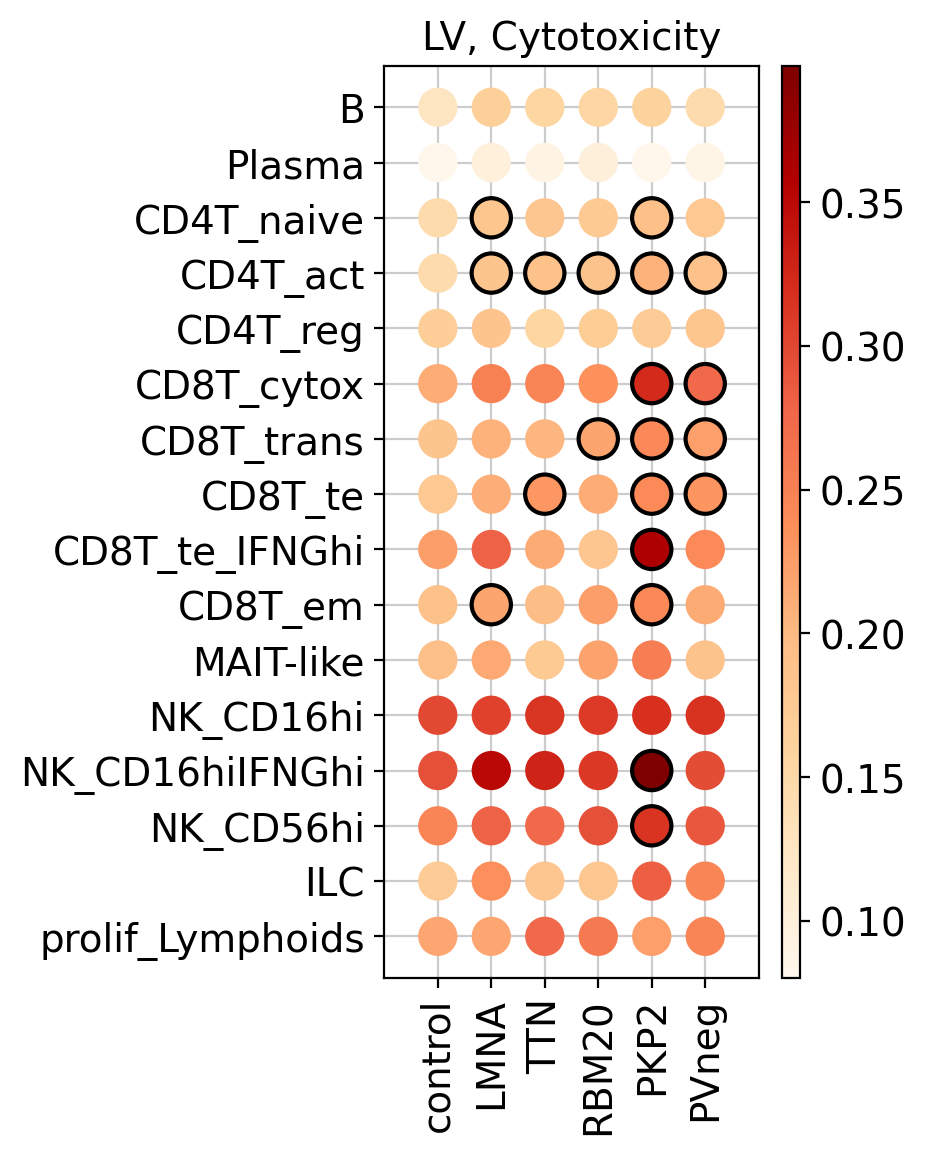

In [13]:
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.facecolor'] = 'none'
plot_scores(LV, geneset=KEGG_cytox, pathway_name='LV, Cytotoxicity', invert_y=True,
           save_png=outdir+'Fig4G_cytox-score_LV.png',dpi=500)

computing score 'RV, Cytotoxicity'
    finished: added
    'RV, Cytotoxicity', score of gene set (adata.obs).
    948 total control genes are used. (0:00:00)


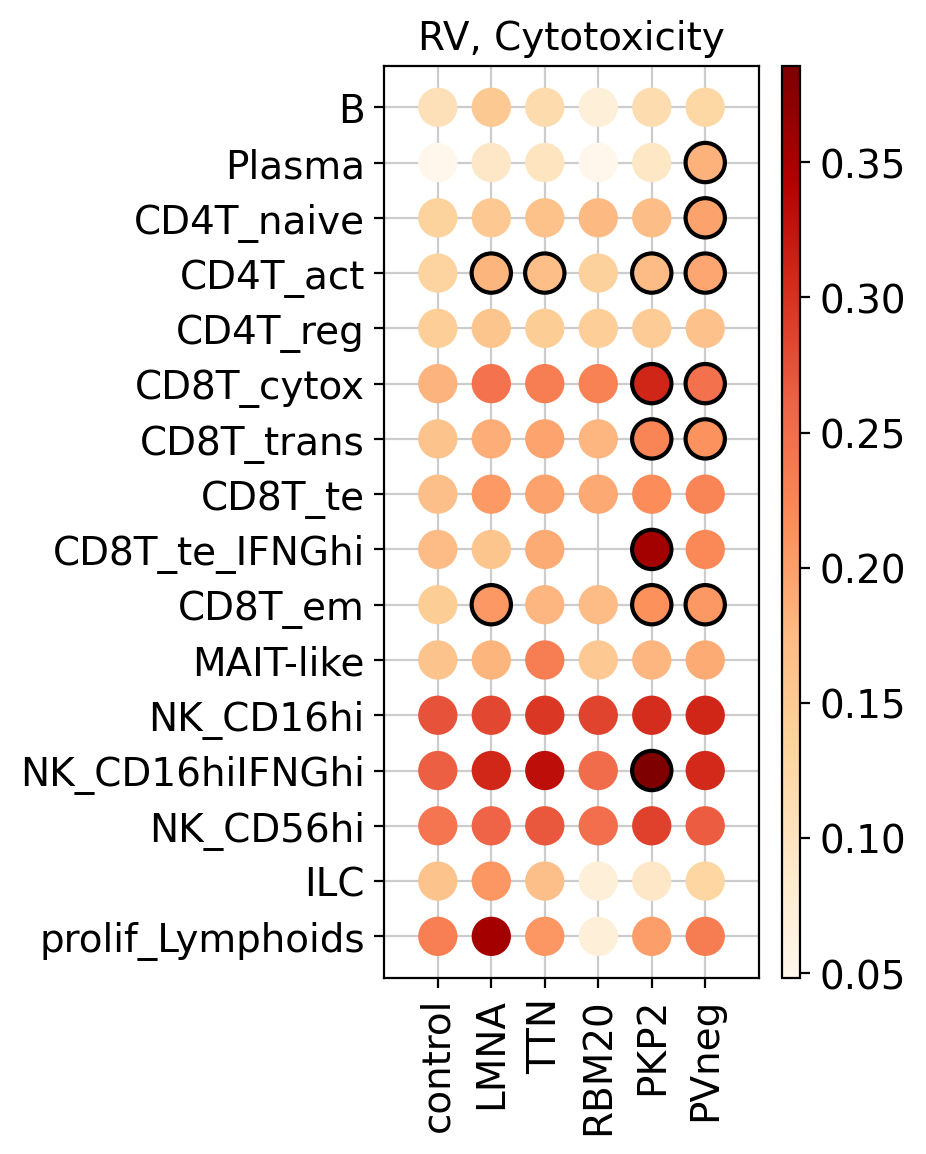

In [14]:
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.facecolor'] = 'none'
plot_scores(RV, geneset=KEGG_cytox, pathway_name='RV, Cytotoxicity', invert_y=True,
           save_png=outdir+'SupFig16F_cytox-score_RV.png',dpi=500)

### Transendothelial migration

computing score 'LV, Transendo migrat'
    finished: added
    'LV, Transendo migrat', score of gene set (adata.obs).
    1144 total control genes are used. (0:00:00)


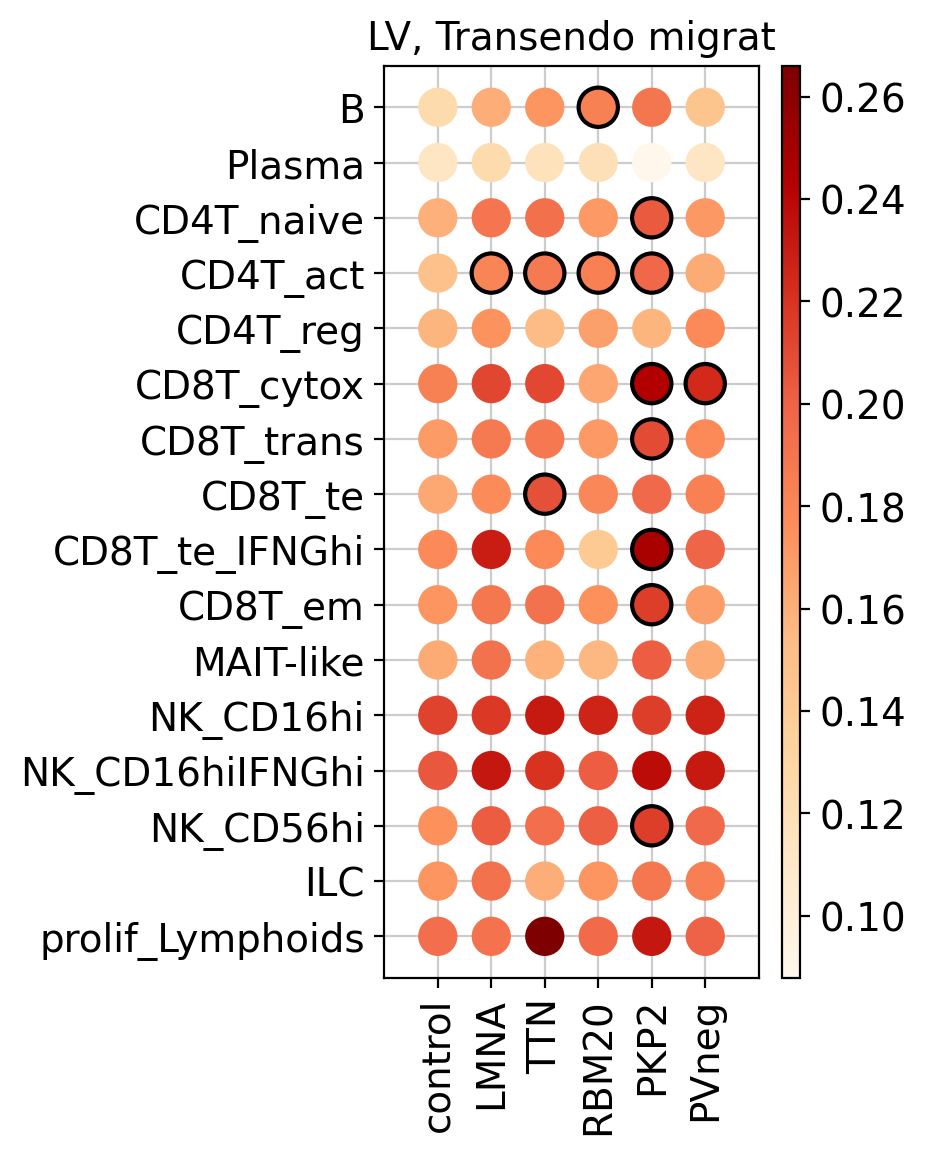

In [15]:
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.facecolor'] = 'none'
plot_scores(LV, geneset=KEGG_LTEM, pathway_name='LV, Transendo migrat', invert_y=True,
           save_png=outdir+'Fig4G_transendo-score_LV.png',dpi=500)

computing score 'RV, Transendo migration'
    finished: added
    'RV, Transendo migration', score of gene set (adata.obs).
    1097 total control genes are used. (0:00:00)


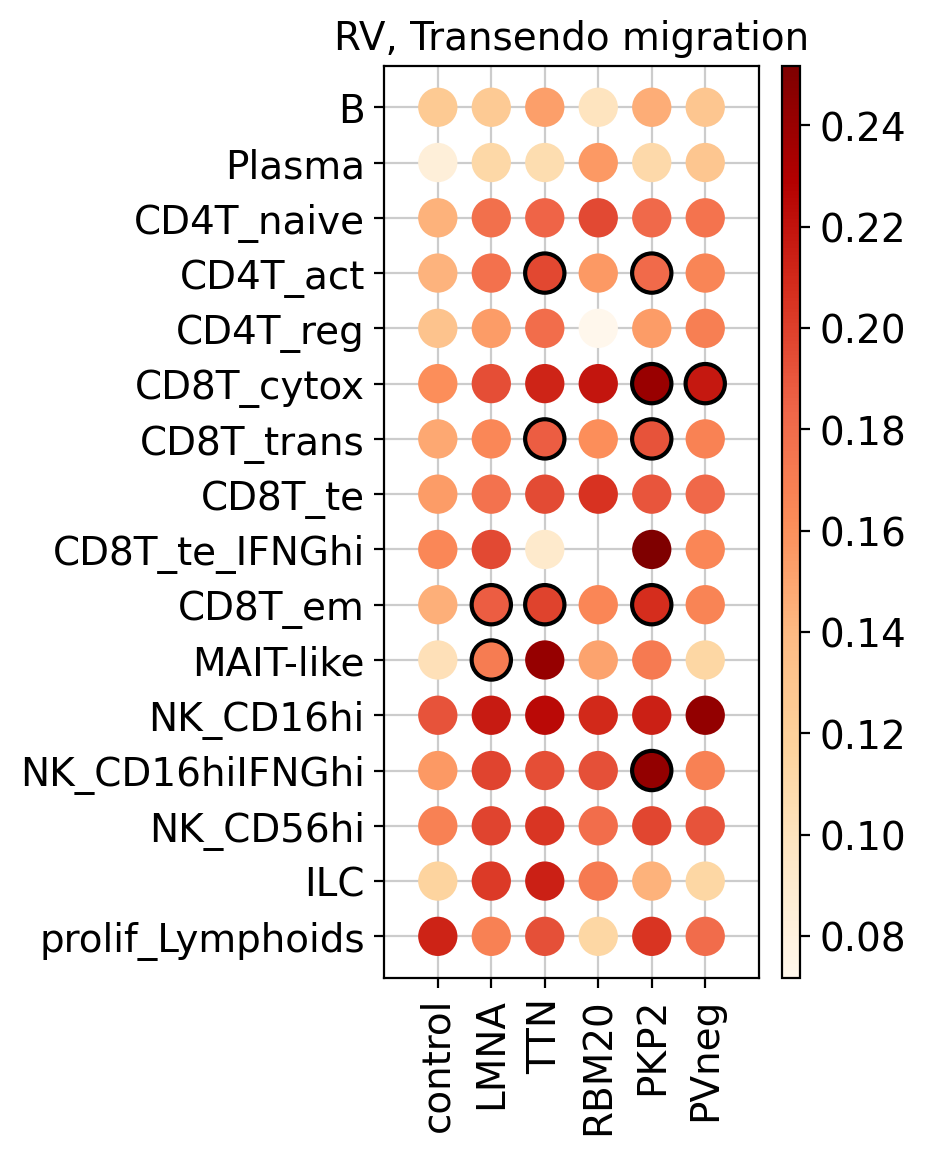

In [16]:
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.facecolor'] = 'none'
plot_scores(RV, geneset=KEGG_LTEM, pathway_name='RV, Transendo migration', invert_y=True,
           save_png=outdir+'SupFig16F_transendo-score_RV.png',dpi=500)

### Cell cycle

computing score 'LV, Cell cycle'
    finished: added
    'LV, Cell cycle', score of gene set (adata.obs).
    995 total control genes are used. (0:00:00)


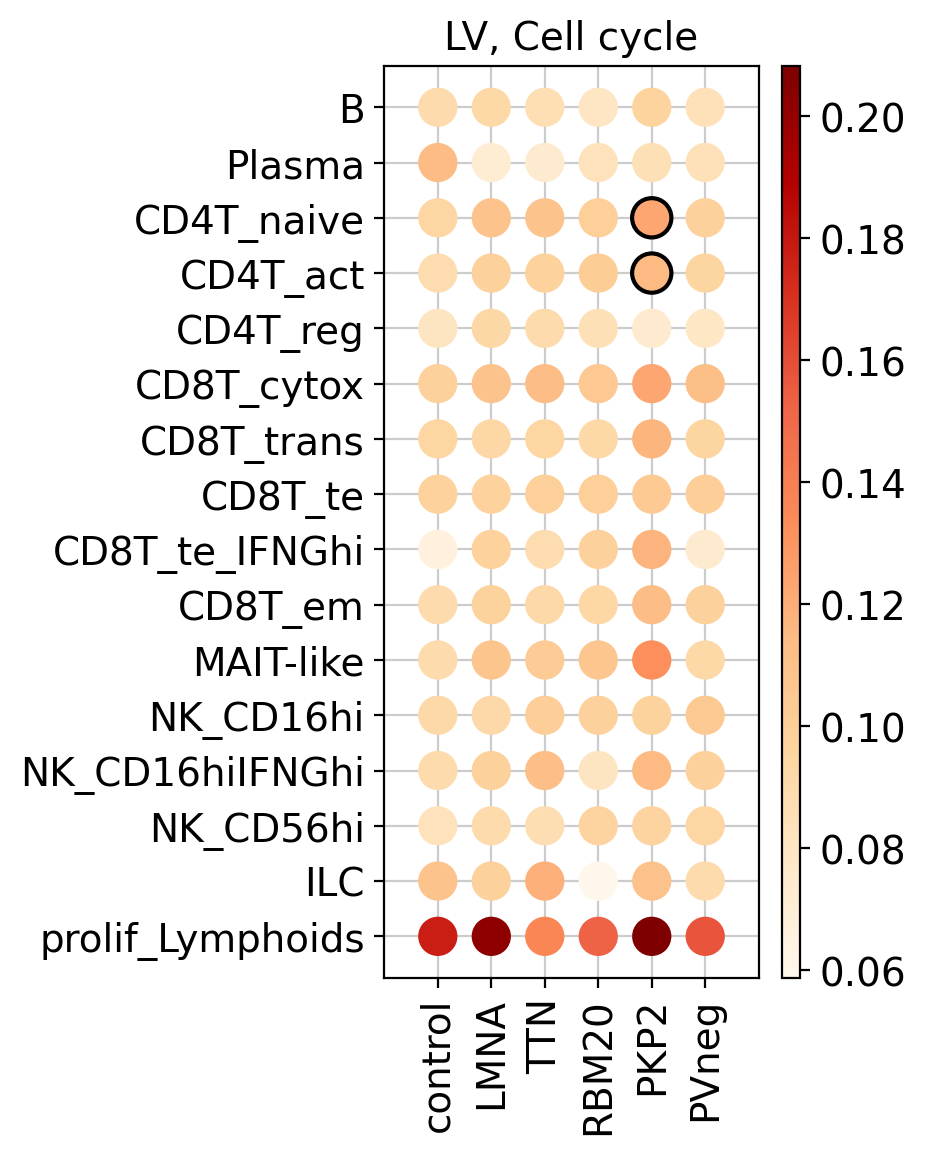

In [17]:
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.facecolor'] = 'none'
plot_scores(LV, geneset=KEGG_CC, pathway_name='LV, Cell cycle', invert_y=True, yticks=True,
           save_png=outdir+'Fig4G_cellcycle-score_LV.png',dpi=500)

computing score 'RV, Cell cycle'
    finished: added
    'RV, Cell cycle', score of gene set (adata.obs).
    1092 total control genes are used. (0:00:00)


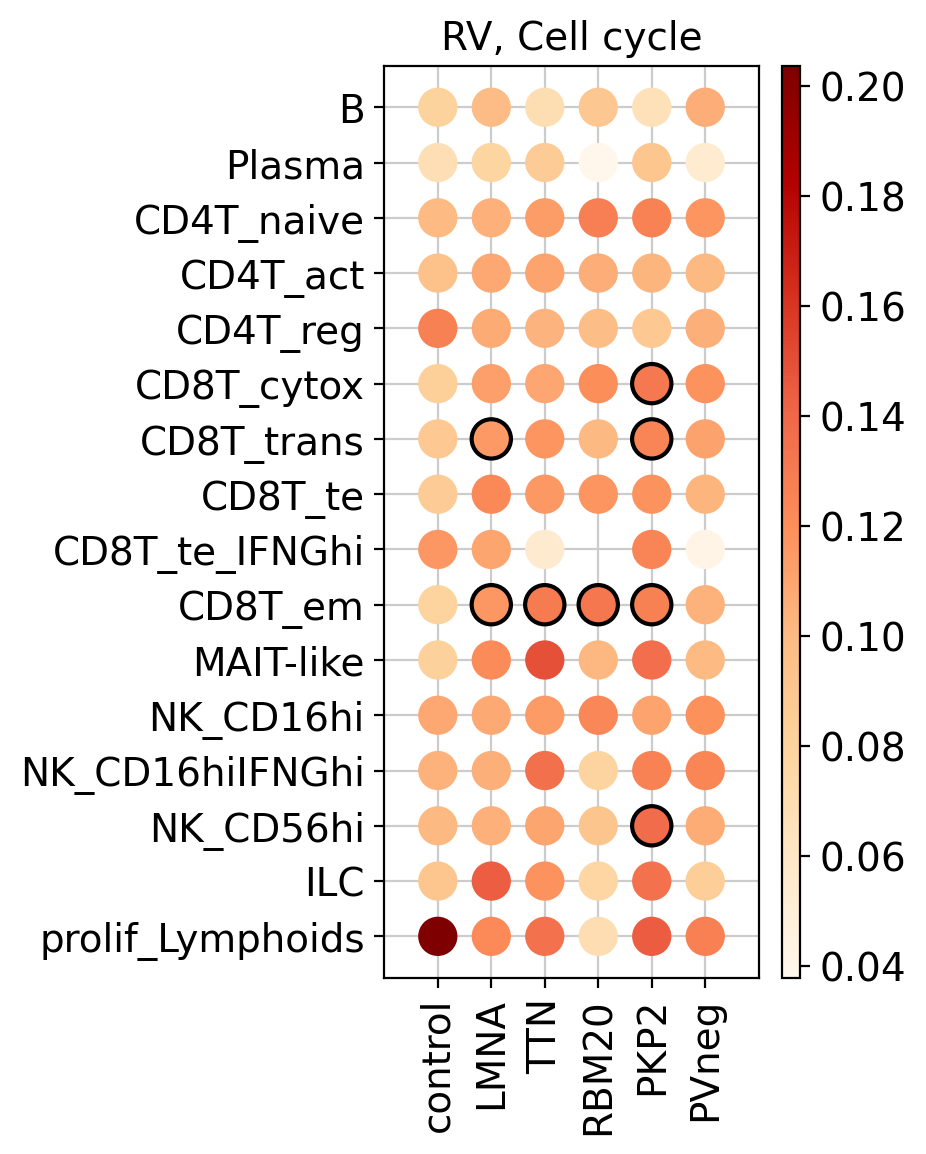

In [18]:
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.facecolor'] = 'none'
plot_scores(RV, geneset=KEGG_CC, pathway_name='RV, Cell cycle', invert_y=True, yticks=True,
           save_png=outdir+'SupFig16F_cellcycle-score_RV.png',dpi=500)

## CD4T characterisation

### Define Th modules from a PBMC dataset

Refer to covid PBMC dataset (Stephenson et al., Nat Med, 2021)

In [19]:
# read in normalised pbmc dataset
pbmc = sc.read_h5ad('/nfs/team205/kk18/Public/Covid/haniffa21.processed.h5ad')
pbmc

AnnData object with n_obs × n_vars = 691683 × 31279
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'Resample', 'Collection_Day', 'Sex', 'Age', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'initial_clustering', 'full_clustering'
    var: 'feature_types'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'

In [20]:
# subset CD4T
CD4Ts = pbmc[pbmc.obs['full_clustering'].isin(['CD4.Naive','CD4.CM','CD4.EM','CD4.IL22','CD4.Prolif','CD4.Tfh','CD4.Th1','CD4.Th17','CD4.Th2'])]
del pbmc
sc.pp.filter_genes(CD4Ts, min_cells=3)
CD4Ts

filtered out 10405 genes that are detected in less than 3 cells
Trying to set attribute `.var` of view, copying.


AnnData object with n_obs × n_vars = 149029 × 20874
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'Resample', 'Collection_Day', 'Sex', 'Age', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'initial_clustering', 'full_clustering'
    var: 'feature_types', 'n_cells'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'

In [21]:
# subset Ths
CD4Ts=CD4Ts[CD4Ts.obs['full_clustering'].isin(['CD4.Tfh','CD4.Th1','CD4.Th17','CD4.Th2'])]
print(CD4Ts.X.data[:10])
CD4Ts

[0.05686952 0.41629794 0.18030061 0.3537609  0.08412979 0.25495404
 0.07077698 0.31569332 0.342126   0.46943945]


View of AnnData object with n_obs × n_vars = 14192 × 20874
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'Resample', 'Collection_Day', 'Sex', 'Age', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'initial_clustering', 'full_clustering'
    var: 'feature_types', 'n_cells'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'

In [22]:
# Identify DEGs
sc.tl.rank_genes_groups(CD4Ts, 'full_clustering', method='wilcoxon')

ranking genes
Trying to set attribute `.uns` of view, copying.
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:17)


    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_full_clustering']`
categories: CD4.Tfh, CD4.Th1, CD4.Th17, etc.
var_group_labels: Th1, Th2, Th17, etc.


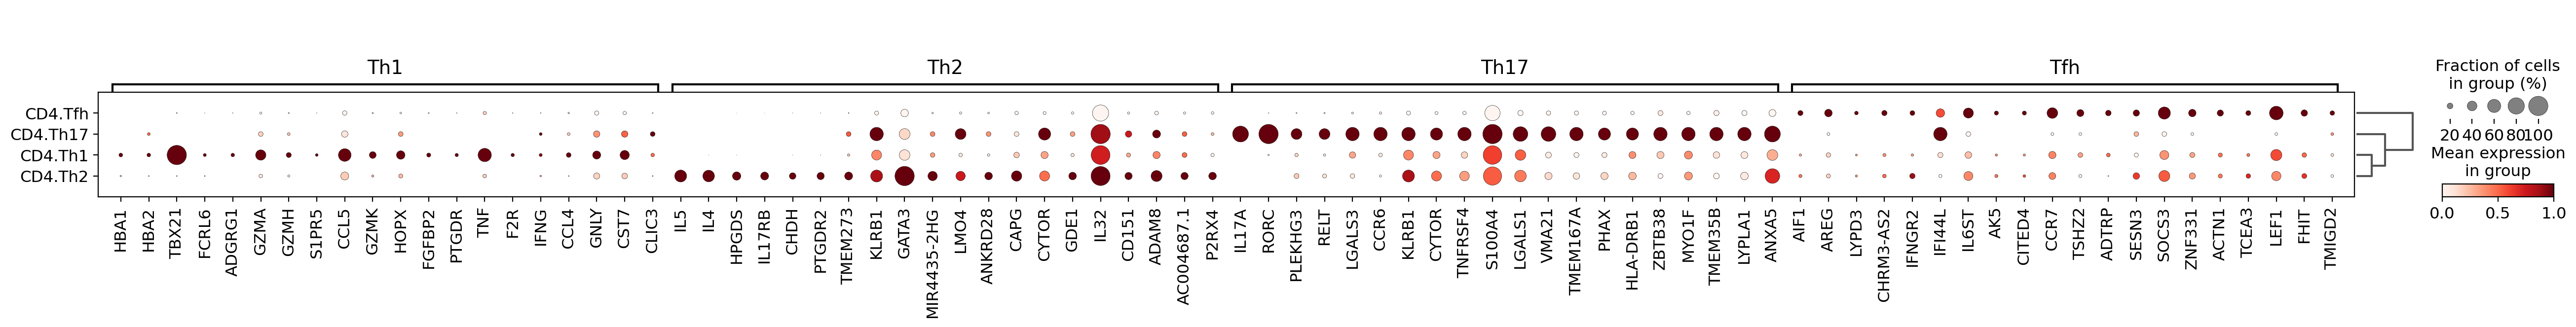

In [23]:
# Select top20 DEGs for each Th and define as Th modules
sigthresh = 'pvals<0.01'
n_gene = 20

highFCgenes={
    'Th1':list(rank_genes_groups_to_df(CD4Ts,'CD4.Th1').query(sigthresh).sort_values('logfoldchanges', ascending=False)[:n_gene]['names']),
    'Th2':list(rank_genes_groups_to_df(CD4Ts,'CD4.Th2').query(sigthresh).sort_values('logfoldchanges', ascending=False)[:n_gene]['names']),
    'Th17':list(rank_genes_groups_to_df(CD4Ts,'CD4.Th17').query(sigthresh).sort_values('logfoldchanges', ascending=False)[:n_gene]['names']),
    'Tfh':list(rank_genes_groups_to_df(CD4Ts,'CD4.Tfh').query(sigthresh).sort_values('logfoldchanges', ascending=False)[:n_gene]['names']),
}

sc.tl.dendrogram(CD4Ts, groupby='full_clustering')
sc.pl.dotplot(
    CD4Ts,
    highFCgenes,
    groupby="full_clustering",
    color_map="Reds",
    standard_scale="var",
    dendrogram=True,
)

### Subset CD4T from DCM data and score Th modules

In [24]:
LV_CD4Tact = LV[LV.obs['cell_states']=='CD4T_act']
RV_CD4Tact = RV[RV.obs['cell_states']=='CD4T_act']

computing score 'Th1'
    finished: added
    'Th1', score of gene set (adata.obs).
    600 total control genes are used. (0:00:00)
computing score 'Th2'
    finished: added
    'Th2', score of gene set (adata.obs).
    648 total control genes are used. (0:00:00)
computing score 'Th17'
    finished: added
    'Th17', score of gene set (adata.obs).
    550 total control genes are used. (0:00:00)
computing score 'Tfh'
    finished: added
    'Tfh', score of gene set (adata.obs).
    598 total control genes are used. (0:00:00)


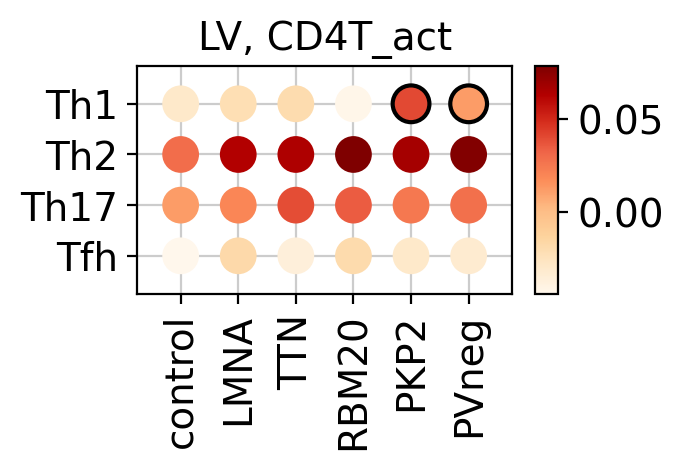

In [25]:
plot_scores2(LV_CD4Tact, highFCgenes, 'LV, CD4T_act', invert_y=True, yticks=True, 
              figsize=(3,1.5), margin_x=0.15, margin_y=0.25,dot_size=175,
             save_png=outdir+'Fig4H_Th-score_LV.png',dpi=500)

computing score 'Th1'
    finished: added
    'Th1', score of gene set (adata.obs).
    450 total control genes are used. (0:00:00)
computing score 'Th2'
    finished: added
    'Th2', score of gene set (adata.obs).
    597 total control genes are used. (0:00:00)
computing score 'Th17'
    finished: added
    'Th17', score of gene set (adata.obs).
    498 total control genes are used. (0:00:00)
computing score 'Tfh'
    finished: added
    'Tfh', score of gene set (adata.obs).
    500 total control genes are used. (0:00:00)


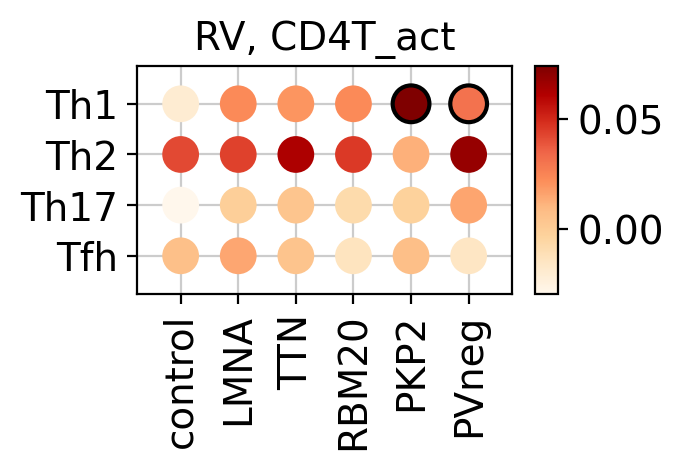

In [26]:
plot_scores2(RV_CD4Tact, highFCgenes, 'RV, CD4T_act', invert_y=True, yticks=True, 
              figsize=(3,1.5), margin_x=0.15, margin_y=0.25,dot_size=175,
             save_png=outdir+'Fig4H_Th-score_RV.png',dpi=500)

### Major Th gene expressions

In [27]:
highFCgenes_sel={
    'Th1': ['TBX21','IFNG'],
    'Th2': ['GATA3','HPGDS','IL17RB','IL4','IL5'],
    'Th17': ['RORC','IL17A','IL22'],
}

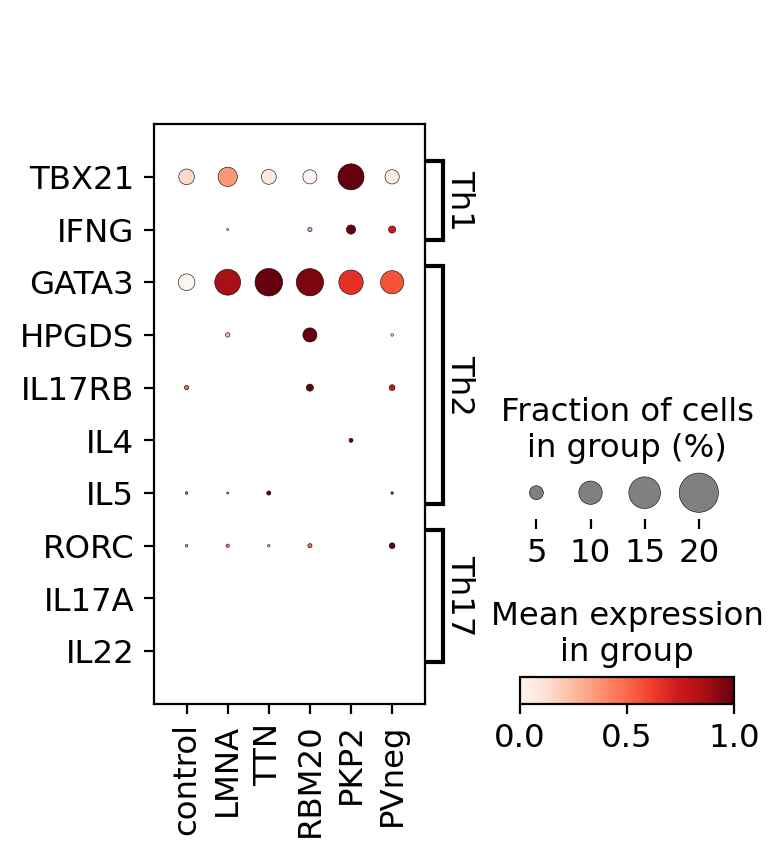

In [28]:
sc.pl.dotplot(
    LV_CD4Tact,
    highFCgenes_sel,
    groupby="Gene",
    color_map="Reds",
    standard_scale="var",
    swap_axes=True,
    save='SupFig16G_Th-genes_LV.png'
)

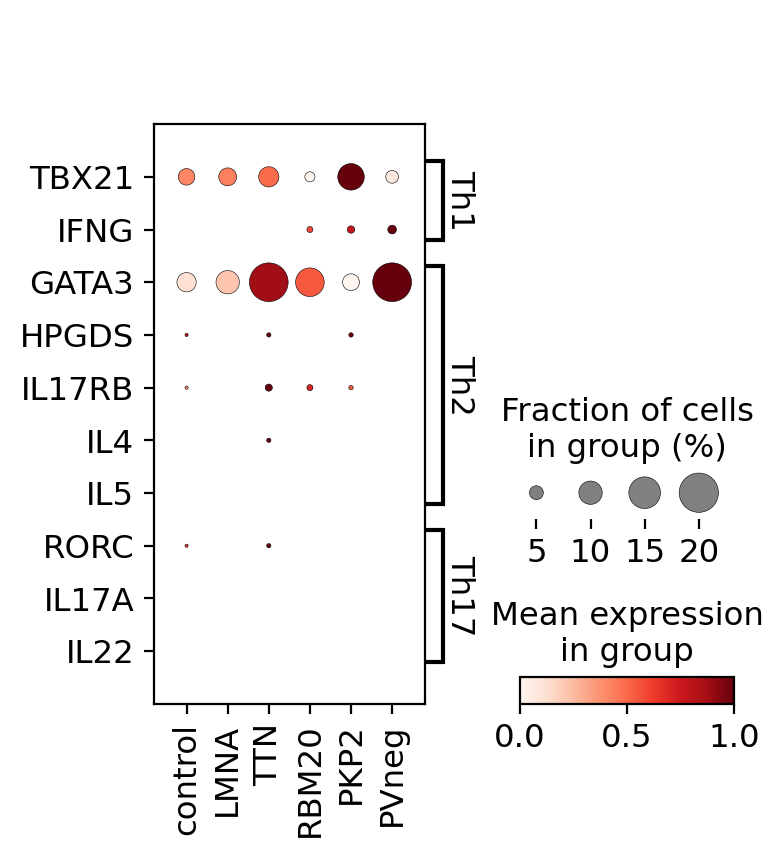

In [29]:
sc.pl.dotplot(
    RV_CD4Tact,
    highFCgenes_sel,
    groupby="Gene",
    color_map="Reds",
    standard_scale="var",
    swap_axes=True,
    save='SupFig16G_Th-genes_RV.png'
)